In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("ggplot")
from textwrap import wrap
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
import string
import nltk
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from datasets import load_dataset


/Users/theodore/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# huggin face dataset
dataset1 = load_dataset("artem9k/ai-text-detection-pile")

df = pd.DataFrame(dataset1['train'].to_pandas())
df = df[['text','source']]
df['source'] = df['source'].map({'human': 0, 'ai': 1})

In [3]:
# using m1 mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
print(df)



                                                      text  source
0        12 Years a Slave: An Analysis of the Film Essa...       0
1        20+ Social Media Post Ideas to Radically Simpl...       0
2        2022 Russian Invasion of Ukraine in Global Med...       0
3        533 U.S. 27 (2001) Kyllo v. United States: The...       0
4        A Charles Schwab Corporation Case Essay\n\nCha...       0
...                                                    ...     ...
1392517  Today, I accomplished a major feat. I stepped ...       1
1392518  As rockets rain down from the sky\nEurope trem...       1
1392519  On January 6th, 2023, the world lost a true pi...       1
1392520  A gene bank is a repository of genetic materia...       1
1392521  On the twelfth day of Christmas, My true love ...       1

[1392522 rows x 2 columns]


In [5]:
# 60% Training, 20% Validation, 20% Test
#train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  
#valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  

#print("Training set size:", len(train_df))
#print("Validation set size:", len(valid_df))
#print("Test set size:", len(test_df))

In [6]:
df0_text = df[df['source'] == 0].copy()
df1_ai = df[df['source'] == 1].copy()

train_df = pd.concat([df0_text,df1_ai], ignore_index=True)
train_df
print("Data set size size:", len(train_df))

Data set size size: 1392522


In [7]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/theodore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from tqdm.notebook import tqdm
from collections import Counter
import string

porter = PorterStemmer()

# establish stop words and linking words
stop_words = set(stopwords.words('english'))
linking_words = {'to', 'the', 'and', 'of', 'in', 'on', 'for', 'with', 'at', 'a', 'an'}

# sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyze_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in linking_words]
    counts = Counter(text)
    punctuation_count = sum(counts[char] for char in string.punctuation)
    linking_words_count = sum(token in linking_words for token in tokens)
    sentiment_scores = sid.polarity_scores(text)
    return pd.Series([len(tokens), sentiment_scores['compound'], punctuation_count, linking_words_count])

# Convert 'text' column to lowercase for df0_text and df1_ai
df0_text['text'] = df0_text['text'].str.lower()
df1_ai['text'] = df1_ai['text'].str.lower()

# Apply the analyze_text function to the 'text' column
tqdm.pandas(desc="Processing df0_text")
df0_text[['text_length', 'sentiment_score', 'punctuation_count', 'linking_words_count']] = df0_text['text'].progress_apply(analyze_text)

tqdm.pandas(desc="Processing df1_ai")
df1_ai[['text_length', 'sentiment_score', 'punctuation_count', 'linking_words_count']] = df1_ai['text'].progress_apply(analyze_text)

Processing df0_text:   0%|          | 0/1028146 [00:00<?, ?it/s]

In [ ]:
#def count_punctuation_marks(text):
    #punctuation_count = sum(1 for char in text if char in string.punctuation)
    #return punctuation_count

#def count_linking_words(text):
    #linking_words_count = sum(1 for word in word_tokenize(text.lower()) if word in linking_words)
    #return linking_words_count
    
#df0_text['punctuation_count'] = df0_text['text'].apply(count_punctuation_marks)
#df1_ai['punctuation_count'] = df1_ai['text'].apply(count_punctuation_marks)

#df0_text['linking_words_count'] = df0_text['text'].apply(count_linking_words)
#df1_ai['linking_words_count'] = df1_ai['text'].apply(count_linking_words)

In [ ]:
df_train = pd.concat([df0_text,df1_ai], ignore_index=False)

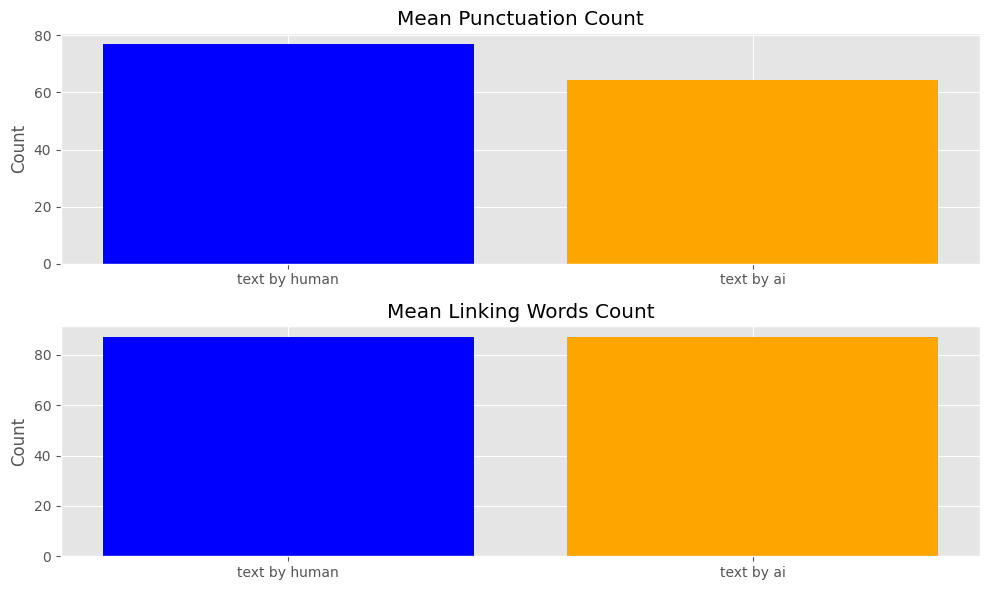

In [ ]:
# Calculate the mean punctuation count and linking words count for human texts
human_mean_punctuation = df0_text.iloc[:]['punctuation_count'].mean()
human_mean_linking_words = df0_text.iloc[:]['linking_words_count'].mean()

# Calculate the mean punctuation count and linking words count for ai texts
ai_mean_punctuation = df1_ai.iloc[:]['punctuation_count'].mean()
ai_mean_linking_words = df1_ai.iloc[:]['linking_words_count'].mean()


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(['text by human', 'text by ai'], [human_mean_punctuation, ai_mean_punctuation], color=['blue', 'orange'])
plt.title('Mean Punctuation Count')
plt.ylabel('Count')


plt.subplot(2, 1, 2)
plt.bar(['text by human', 'text by ai'], [human_mean_linking_words, ai_mean_linking_words], color=['blue', 'orange'])
plt.title('Mean Linking Words Count')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
df_train_copy = df_train.copy()

df_train_copy.drop(['text_length', 'sentiment_score'], axis=1, inplace=True)
print(df_train_copy.head())
df_train_copy.fillna(0, inplace=True)

df_train_copy

                                                     text  source  \
416362  No - one knows what the actual answer is , but...       0   
379434  Last week, I received this email from Rennae:\...       0   
465012  ``What the hell is wrong with you? Get up now!...       0   
919289  ``Come on Ben, just a couple floors, it'll be ...       0   
399462  The snow has dust particles around which the f...       0   

        punctuation_count  linking_words_count  
416362                  8                    9  
379434                180                  146  
465012                 26                   37  
919289                 83                   25  
399462                  5                    7  


,text,source,punctuation_count,linking_words_count
416362,"No - one knows what the actual answer is , but...",0,8,9
379434,"Last week, I received this email from Rennae:\...",0,180,146
465012,``What the hell is wrong with you? Get up now!...,0,26,37
919289,"``Come on Ben, just a couple floors, it'll be ...",0,83,25
399462,The snow has dust particles around which the f...,0,5,7
...,...,...,...,...
1370455,The Supreme Court is a branch of the federal g...,1,16,66
1113396,Tasmania has taken a positive step towards ren...,1,59,101
1239911,The US-led coalition has-been has been fightin...,1,102,214
1136074,I don't know why I'm such an expert at getting...,1,161,135


In [ ]:
# Function to tokenize text and remove stopwords
def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.isalpha() and token not in stop_words]

# Tokenize all texts and count word occurrences
all_words = [word for text in df_train_copy['text'] for word in tokenize_text(text)]
word_counts = Counter(all_words)

# Select the top 500 most common words as features
top_words = [word for word, _ in word_counts.most_common(500)]

def featurize_text(text):
    # Tokenize text and calculate text length
    tokens = tokenize_text(text)
    length_text = len(tokens)
    
    # Calculate word features
    word_features = [1 if word in tokens else 0 for word in top_words]
    
    # Calculate punctuation and linking words percentages
    token_length = len(word_tokenize(text))
    punctuation_count = count_punctuation_marks(text) / token_length * 100 if token_length != 0 else 0
    linking_words_count = count_linking_words(text) / token_length * 100 if token_length != 0 else 0
    
    return length_text, word_features, punctuation_count, linking_words_count

# Apply the featurize_text function to the 'text' column
df_train_copy[['length_text', 'word_features', 'punctuation_count_percentage', 'linking_words_percentage']] = df_train_copy['text'].apply(featurize_text).apply(pd.Series)
df_train_copy

,text,source,punctuation_count,linking_words_count,length_text,word_features
416362,"No - one knows what the actual answer is , but...",0,8,9,87,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
379434,"Last week, I received this email from Rennae:\...",0,180,146,945,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
465012,``What the hell is wrong with you? Get up now!...,0,26,37,200,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ..."
919289,"``Come on Ben, just a couple floors, it'll be ...",0,83,25,235,"[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
399462,The snow has dust particles around which the f...,0,5,7,36,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1370455,The Supreme Court is a branch of the federal g...,1,16,66,213,"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
1113396,Tasmania has taken a positive step towards ren...,1,59,101,519,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ..."
1239911,The US-led coalition has-been has been fightin...,1,102,214,967,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."
1136074,I don't know why I'm such an expert at getting...,1,161,135,960,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


In [ ]:
# Function to calculate percentage of punctuation in a text
#def calculate_punctuation_count(text):
#    token_length = len(word_tokenize(text))
#    return count_punctuation_marks(text) / token_length * 100 if token_length != 0 else 0

#df_train_copy['punctuation_count_percentage'] = df_train_copy['text'].apply(calculate_punctuation_count)

# Function to calculate percentage of linking words in a text
#def calculate_linking_words_count(text):
#    token_length = len(word_tokenize(text))
#    return count_linking_words(text) / token_length * 100 if token_length != 0 else 0

# Add a column to df0_text for linking words percentage
#df_train_copy['linking_words_percentage'] = df_train_copy['text'].apply(calculate_linking_words_count)

In [ ]:
df_train_copy

,text,source,punctuation_count,linking_words_count,length_text,word_features,punctuation_count_percentage,linking_words_percentage
416362,"No - one knows what the actual answer is , but...",0,8,9,87,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.195402,10.344828
379434,"Last week, I received this email from Rennae:\...",0,180,146,945,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",19.047619,15.449735
465012,``What the hell is wrong with you? Get up now!...,0,26,37,200,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...",13.000000,18.500000
919289,"``Come on Ben, just a couple floors, it'll be ...",0,83,25,235,"[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",35.319149,10.638298
399462,The snow has dust particles around which the f...,0,5,7,36,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",13.888889,19.444444
...,...,...,...,...,...,...,...,...
1370455,The Supreme Court is a branch of the federal g...,1,16,66,213,"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",7.511737,30.985915
1113396,Tasmania has taken a positive step towards ren...,1,59,101,519,"[1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...",11.346154,19.423077
1239911,The US-led coalition has-been has been fightin...,1,102,214,967,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...",10.548087,22.130300
1136074,I don't know why I'm such an expert at getting...,1,161,135,960,"[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",16.701245,14.004149


Accuracy: 0.8346126532989699
Train Loss: 0.3215098216781007
Test Loss: 0.34943973950332063
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89    185182
           1       0.70      0.64      0.67     65472

    accuracy                           0.83    250654
   macro avg       0.79      0.77      0.78    250654
weighted avg       0.83      0.83      0.83    250654

Class-wise Metrics:
              precision    recall  f1-score        support
0              0.876527  0.903398  0.889759  185182.000000
1              0.700828  0.640060  0.669067   65472.000000
accuracy       0.834613  0.834613  0.834613       0.834613
macro avg      0.788677  0.771729  0.779413  250654.000000
weighted avg   0.830633  0.834613  0.832113  250654.000000


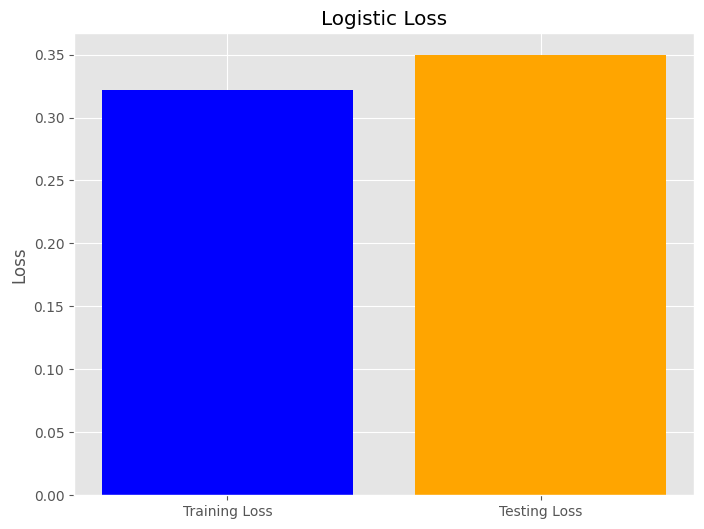

In [ ]:
# Define features (word features, punctuation count, count of synonyms) and target variable
X = pd.DataFrame(df_train_copy['word_features'].tolist(), columns=top_words)
X['punctuation_count_percentage'] = df_train_copy['punctuation_count_percentage']
X['linking_words_percentage'] = df_train_copy['linking_words_percentage']
X['length_text'] = df_train_copy['length_text']
y = df_train_copy['source']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize SimpleImputer, Fit and transform the imputer on the feature matrix X, Initialize and train the Logistic Regression classifier
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_imputed, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_imputed)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
train_loss = log_loss(y_train, model.predict_proba(X_train_imputed)) # Calculate logistic loss for training and testing sets
test_loss = log_loss(y_test, model.predict_proba(X_test_imputed))
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Calculate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Parse the classification report to get individual class metrics
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Class-wise Metrics:")
print(class_report_df)

# Plotting the Loss
loss_values = [train_loss, test_loss]
labels = ['Training Loss', 'Testing Loss']

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Logistic Loss')
plt.ylabel('Loss')
plt.show()